# Preface

If you were to generate every single possible permutation of pixels in an image of a given size and color depth, then you would in your possession _every_ image of that size and color depth that there was _or ever will be_.

This is really cool!

Imagine digging into that pandora's box with machine learning to identity objects..

Could you dig out images from the past?

From the future?

Is this where technology and philosophy meet.. again?

# The goal

It doesn't make sense to generate all of these images in advance, because there'd be an awful lot of them and the majority of them would be utterly incomprehensible noise.

It also doesn't make sense to randomly generate all of these images, since you could never guarantee they would _all_ be generated, nor that you wouldn't see the same image more than once.

So the idea is to create an algorithm or a process to generate an image _deterministically_ using an index to uniquely identify it.

# The problem

To generate _actually useful_ images they would need to be of a decent size and color depth. However beyond a certain point the number of permutations becomes incomprehensible and actually inaccessible. Computers simply can't count that high.

The number of permutations for 256x256 image with 256 colors is too large for Python to even just display without an error.

So we need to find a way to drastically reduce the size of the numbers, without losing any precision, while still being able to traverse permutations sequentially.

# Determining the number of images

In [1]:
def num_permutations(num_pixels, num_colors):
    return num_colors ** num_pixels

# Generating a pixel

In [8]:
def get_pixel(index, pixel_index, num_pixels, num_colors):
    return int((index / (num_colors ** pixel_index)) % num_colors)

# Generating an image

In [10]:
def get_image(index, num_pixels, num_colors):
    return list(map(lambda i: get_pixel(index, i, num_pixels, num_colors), range(0, num_pixels)))

# A trivial example

In [4]:
# Set some variables
num_pixels = 9
num_colors = 2

In [5]:
# Print the number of permutations
num_permutations(num_pixels, num_colors)

512

In [12]:
# Get the first image
get_image(0, num_pixels, num_colors)

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
# Get the last image
get_image(num_permutations(num_pixels, num_colors) - 1, num_pixels, num_colors)

[1, 1, 1, 1, 1, 1, 1, 1, 1]

# An advanced example

In [117]:
from PIL import Image

def generate_image(data, image_size, num_colors):
    image = Image.new('RGB', (image_size, image_size))
    
    for y in range(0, image_size - 1):
        for x in range(0, image_size - 1):
            color = int((255 / num_colors) * data[x + y])
            image.putpixel((x, y), (color, color, color))
    
    return image

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


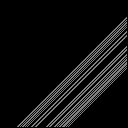

In [118]:
# Generate an image
image_size = 128
num_colors = 2

data = get_image(34295879348759340958304582374592734569874596345984756947567, image_size * image_size, num_colors)

generate_image(data, image_size, num_colors)